# Segmentation
Imports and define names of datafiles

In [1]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm  
from typing import List,Tuple
import torch.nn as nn
import numpy as np
import regex as re
import random
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
datafiles= {
  "E1" : [''],
  "E2" : ['a', 'b'],
  "E3" : [''],
  "E4" : ['']
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Function that extracts headwords out of \<b\> tags to build a headword dataset.

In [2]:
def build_b_tag_dataset(datastring, next_chars = 500, verbose=False):
  b_tag_dict = []

  # BUILD POSITIVE 
  for match in tqdm(re.finditer(r"((?<=<b>).+<\/b>)(.*(?<=<b>).+<\/b>)*", datastring), disable=(not verbose)):
    g1 = match.group(0)
    matched_b_tag = re.sub(r"</b>.*<b>|</b>"," ",g1).strip()
    end_of_b_tag = match.end()  
    
    surrounding_text_match = re.search(r"([^<]{1,"+str(next_chars)+r"})(?=<|$)", datastring[end_of_b_tag:end_of_b_tag+next_chars])
    surrounding_text = surrounding_text_match.group(0) if surrounding_text_match else ""

    short_def = re.sub(r"\s+", " ", surrounding_text).strip()
    if len(short_def) > 0:
      b_tag_dict.append([f"{matched_b_tag} {short_def}", matched_b_tag])

  # BUILD NEGATIVE
  for match in tqdm(re.finditer(r"(\n\n\p{Upper}[^<]{10,500})(?=\n|$|<)", datastring), disable=(not verbose)):
    g = match.group(0)
    matched_text = re.sub(r"\s+", " ", g).strip()
    b_tag_dict.append([matched_text, ""])

  return b_tag_dict

Build the headword datasets for the first and second editions (E1 \& E2) where for each entry there is:
  - Feature: A paragraph or piece of text that starts with a headword, followed by up to <i>next_chars</i> number of characters, default is 500.
  - label: The headword at the beginning of the corresponding feature, empty string if feature wasn't a <i>"headword"</i> paragraph.

Save results to json files:
```json
  ["Lund, uppstad i Malmöhus län...beskaffenhet. I all", "Lund,"]
  ["betjenade sig af rapporter från...till privatlifvet", ""]
```

In [3]:
def build_json_headword_set():
  for i,edition in enumerate(['E1', 'E2']):

    dataset = ""
    for file in datafiles.get(edition):
      with open(f"./dataset/NF_{edition}{file}.txt", "r", encoding='utf-8') as fr:
        dataset += fr.read()
        fr.close()
        
    b_tag_dict = build_b_tag_dataset(dataset, verbose=True)
    print(f"{edition} has {len(b_tag_dict):,} entries")

    with open(f"./dataset/NF_{edition}_B.json", "w") as b_json:
      json.dump(b_tag_dict, b_json, indent=2, ensure_ascii=False)
  del i, edition, dataset, file, fr, b_tag_dict, b_json
# build_json_headword_set()

In [4]:
def load_headword_dataset():
  dataset = []
  for edition in ['E1', 'E2']:
      with open(f"./dataset/NF_{edition}_B.json", "r", encoding='utf-8') as b_json:
        dataset += json.load(b_json)
        b_json.close()
  return dataset

def process_data(sentence, headword):
    encoded_sentence = tokenizer(
        sentence,
        add_special_tokens=True, 
        padding='max_length',   
        max_length=100,        
        truncation=True,       
        return_tensors='pt'  
    )
    encoded_headword = tokenizer(
        headword,
        add_special_tokens=True,
        padding='max_length',
        max_length=20,           
        truncation=True,
        return_tensors='pt'
    )
    return encoded_sentence['input_ids'][0], encoded_headword['input_ids'][0]

def extract_features_labels(dataset) -> Tuple[List, List]:
    x = []
    y = []
    for entry in tqdm(dataset):
      sentence, headword = process_data(entry[0], entry[1])
      x.append(sentence)

      min_len = min(len(sentence), len(headword))
      headword_mask = np.where((sentence[:min_len] > 4) & (sentence[:min_len] == headword[:min_len]), 1, 0)
      headword_mask = np.pad(headword_mask, (0, len(sentence) - min_len), 'constant')
      
      y.append(torch.tensor(headword_mask))
    return torch.stack(x).to(device), torch.stack(y).to(device)

tokenizer = AutoTokenizer.from_pretrained("KB/bert-base-swedish-cased")
dataset = load_headword_dataset()

random.seed(123)
random.shuffle(dataset)

test_set = dataset[:5000]
dataset = dataset[5000:]

X_test, y_test = extract_features_labels(test_set) # <-- Use this to comapre different models. 
X, y = extract_features_labels(dataset)            # <-- Use this to train our model or fine-tune a model.  

100%|██████████| 303448/303448 [03:13<00:00, 1565.68it/s]


In [13]:
example_index = 1
input = X[example_index]
mask = y[example_index]
headword = X[example_index][torch.flatten(torch.nonzero(y[example_index]))]
print(f"Input Sentence: \n{tokenizer.decode(input, skip_special_tokens=True)}\n")
print(f"Tokenized Sentence: \n{input.tolist()}\n")
print(f"Target Mask: \n{mask.tolist()}\n")
print(f"Target Headword: \n{tokenizer.decode(headword, skip_special_tokens=True)}")

Input Sentence: 
Bondesen, Ingvor, dansk författare, f. 1844, var 186485 skollärare på Fyn, blef därefter anställd i Köpenhamns skolväsen och 1892 skolinspektör vid en af skolorna därstädes. Han började 1877 under märket Henning Fox att skrifva historiska romaner från den äldre medeltiden, Styrismanden og hans brud ( 1877 ) och Kongsbrydens fostersön ( 1878 ). Senare följde berättelser med ämnen från adelsväldets tid, Rettergang og skriftegang

Tokenized Sentence: 
[2, 17431, 436, 19, 1613, 8143, 19, 5908, 4567, 19, 13, 7, 21978, 49841, 19, 96, 42581, 5727, 16964, 4759, 68, 48349, 19, 21829, 49808, 3386, 7410, 31, 32754, 1005, 28343, 36, 35907, 1005, 17969, 252, 59, 4815, 13349, 256, 23055, 7, 371, 1649, 42456, 244, 19997, 15860, 13469, 48, 1147, 49808, 384, 8521, 15797, 146, 97, 2332, 21045, 19, 15307, 2894, 963, 5196, 699, 14503, 177, 42456, 171, 36, 7954, 9213, 389, 148, 11989, 21345, 177, 40999, 171, 7, 9475, 5622, 12631, 66, 7114, 146, 23410, 746, 1730, 353, 290, 19, 17187, 95, 19

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20) # <-- Use to train our model or fine-tune a model.
print("Vocab size:", tokenizer.vocab_size)
print("Max input ID:", torch.max(X_train).item())

Vocab size: 50325
Max input ID: 49968


In [7]:
class HeadwordExtractor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_units, nbr_classes, num_layers=1, bidi_lstm=False):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=tokenizer.pad_token_id)
        self.lstm = nn.LSTM(embedding_dim, lstm_units, num_layers=num_layers, batch_first=True, bidirectional=bidi_lstm)
        if not bidi_lstm:
            self.fc = nn.Linear(lstm_units, nbr_classes)
        else:
            self.fc = nn.Linear(2*lstm_units, nbr_classes)

    def forward(self, sentence):
        embeds = self.embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        lstm_out = nn.functional.relu(lstm_out)
        logits = self.fc(lstm_out)
        return logits

In [8]:
embedding_dim = 128
hidden_dim = 128
batch_size = 32
num_epochs = 5
learning_rate = 0.001

train_dataset = TensorDataset(X_train.long(), y_train.long())
val_dataset = TensorDataset(X_val.long(), y_val.long())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = HeadwordExtractor(tokenizer.vocab_size, embedding_dim, hidden_dim, nbr_classes=2, num_layers=1,bidi_lstm=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model

HeadwordExtractor(
  (embeddings): Embedding(50325, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [9]:
history=[]
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
   
    model.train()
    train_loss = 0
    train_accuracy = 0
    temp = 0
    for input_batch, target_batch in tqdm(train_loader, desc = "Training"):
        outputs = model(input_batch)

        loss = criterion(outputs.view(-1,outputs.shape[-1]), target_batch.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += (torch.sum(outputs.view(-1,outputs.shape[-1]).argmax(dim=1) == target_batch.view(-1))/target_batch.view(-1).shape[0]).item()
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_accuracy / len(train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")

    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_accuracy = 0
        for input_batch, target_batch in tqdm(val_loader, desc = "Validation"):
          outputs = model(input_batch)

          loss = criterion(outputs.view(-1,outputs.shape[-1]), target_batch.view(-1))
          val_loss += loss.item()
          val_accuracy += (torch.sum(outputs.view(-1,outputs.shape[-1]).argmax(dim=1) == target_batch.view(-1))/target_batch.view(-1).shape[0]).item()
    avg_val_loss = val_loss/len(val_loader)
    avg_val_acc = val_accuracy / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}\n")

    history.append((avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc))

Epoch 1/5:


Training: 100%|██████████| 7587/7587 [00:46<00:00, 162.18it/s]


Train Loss: 0.0130, Train Accuracy: 0.9950


Validation: 100%|██████████| 1897/1897 [00:03<00:00, 507.81it/s]


Validation Loss: 0.0093, Validation Accuracy: 0.9964

Epoch 2/5:


Training: 100%|██████████| 7587/7587 [00:45<00:00, 166.30it/s]


Train Loss: 0.0074, Train Accuracy: 0.9972


Validation: 100%|██████████| 1897/1897 [00:03<00:00, 511.96it/s]


Validation Loss: 0.0081, Validation Accuracy: 0.9970

Epoch 3/5:


Training: 100%|██████████| 7587/7587 [00:46<00:00, 161.59it/s]


Train Loss: 0.0056, Train Accuracy: 0.9979


Validation: 100%|██████████| 1897/1897 [00:03<00:00, 519.15it/s]


Validation Loss: 0.0081, Validation Accuracy: 0.9970

Epoch 4/5:


Training: 100%|██████████| 7587/7587 [00:44<00:00, 171.62it/s]


Train Loss: 0.0043, Train Accuracy: 0.9984


Validation: 100%|██████████| 1897/1897 [00:03<00:00, 539.53it/s]


Validation Loss: 0.0085, Validation Accuracy: 0.9971

Epoch 5/5:


Training: 100%|██████████| 7587/7587 [00:47<00:00, 158.94it/s]


Train Loss: 0.0033, Train Accuracy: 0.9988


Validation: 100%|██████████| 1897/1897 [00:03<00:00, 508.17it/s]

Validation Loss: 0.0093, Validation Accuracy: 0.9970



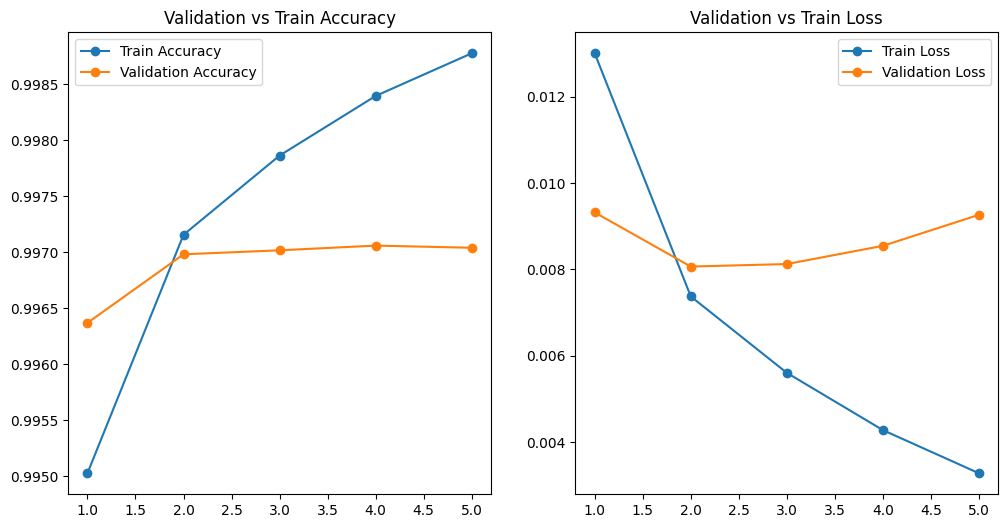

In [10]:
def plot_metrics():
  train_loss, train_acc, val_loss, val_acc = tuple(zip(*history))
  epochs = range(1, len(history) + 1)

  plt.figure(figsize=(12, 6))
  plt.subplot(1,2,1)
  plt.plot(epochs, train_acc, marker='o', linestyle='-', label='Train Accuracy')
  plt.plot(epochs, val_acc, marker='o', linestyle='-', label='Validation Accuracy')
  plt.title('Validation vs Train Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, train_loss, marker='o', linestyle='-', label='Train Loss')
  plt.plot(epochs, val_loss, marker='o', linestyle='-', label='Validation Loss')
  plt.title('Validation vs Train Loss')
  plt.legend()
  plt.show()
plot_metrics() 

In [17]:
print(tokenizer.decode(X_train[example_index], skip_special_tokens=True))
tokenizer.decode(X_train[example_index][torch.flatten(torch.nonzero(y_train[example_index]))], skip_special_tokens=True)

Hjersås, socken i Kristianstads län, delad, med större delen, 7, 540 har, 1, 619 innev. ( 1881 ), å Östra Göinge härad, och en mindre del, 910 har, 170 innev. ( 1881 ), å Villands härad, tillsammans 8, 450 har, 1, 789 innev. H. bildar med Knislinge ett regalt pastorat af 3 : dje kl., Lunds stift, Östra Göinge kontrakt.


'Hjersås,'

In [20]:
model.eval()
input_sentence = "Gustav Vasa, ursprungligen Gustav Eriksson,[2] enligt flera källor född 12 maj 1496, död 29 september 1560 på Tre Kronor i Stockholm.[3] var kung av Sverige 1523–1560 och riksföreståndare 1521–1523, under det pågående befrielsekriget. Hans makttillträde, inlett som ett uppror mot unionskungen Kristian II efter Stockholms blodbad, innebar slutet för"
encoded_input = tokenizer(input_sentence, return_tensors="pt", padding = "max_length", max_length = 100, truncation = True)['input_ids'].to(device)

with torch.no_grad():
    output_mask = model(encoded_input).argmax(dim=-1).view(-1).cpu()

headword = encoded_input.cpu().view(-1)[torch.flatten(torch.nonzero(output_mask))]
print("Predicted headword:", tokenizer.decode(headword, skip_special_tokens=True))

Predicted headword: Gustav Vasa
